<a href="https://colab.research.google.com/github/joey0320/reversemethod/blob/colabcodes/RM_USING_EXCEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/joey0320/reversemethod.git

Cloning into 'reversemethod'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 62 (delta 15), reused 44 (delta 7), pack-reused 0
Unpacking objects: 100% (62/62), done.


In [0]:
!git clone https://github.com/joey0320/reversemethod.git

Cloning into 'reversemethod'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 62 (delta 15), reused 44 (delta 7), pack-reused 0
Unpacking objects: 100% (62/62), done.


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
import cv2
#from DataCaller_Excel import DataCaller_Excel
#from Model import Net
#from EarlyStop import EarlyStopping

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
LOAD_DATA = True
BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
LEARNING_RATE = 2e-3
EPOCHS = 1000
PATIENCE = 5
VALIDATE_EVERY = 8
MODEL_NAME = f"model-{int(time.time())}"
IMG_SIZE = 64
IMG_CHANNELS = 1

cuda


In [0]:
class DataCaller(Dataset):
    def __init__(self, data_path, label_path, input_size):
        
        self.data_path = data_path
        self.label_path = label_path
        self.input_size = input_size
        label = pd.read_excel(open(self.label_path, 'rb'), sheet_name='Sheet2', header=None)
        self.label = torch.from_numpy( np.array(label) ).float()

        self.data = []
        for f in tqdm(os.listdir(self.data_path)):
            path = os.path.join(self.data_path, f)
            img = cv2.imread(path)
            img = cv2.resize(img, (self.input_size, self.input_size))
            self.data.append(np.array(img))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.label[idx])
        return x, y

In [0]:

class DataCaller_Excel(Dataset):
    def __init__(self, data_path, inputsize):
        
        self.data_path = data_path
        self.inputsize = inputsize
        
        data = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet1', header=None)
        data = np.array(data)
        data = data.reshape(-1, 1, inputsize, inputsize)
        self.data = torch.from_numpy(data).float()
        
        label = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet2', header=None)
        self.label = torch.from_numpy( np.array(label) ).float()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.label[idx])
        return x, y

In [0]:

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 12, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(8),
            #nn.Conv2d(8, 12, kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #32 x 32 x 12
            
            nn.Conv2d(12, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.Conv2d(16, 16, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #16 x 16 x 16
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #8 x 8 x 32

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #4 x 4 x 32
            
            nn.Conv2d(32, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #2 x 2 x 48

            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #1 x 1 x 48
            
        )
        self.fcc = nn.Sequential(
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Dropout(0.4),
            #nn.Linear(256, 48),
            #nn.ReLU(),
            #nn.Dropout(0.4),
            nn.Linear(24, 5)
        )
    def forward(self, x):
        output = self.cnn(x)
        output = output.view(output.size(0), -1)
        output = self.fcc(output)
        return output

In [0]:
#data path
DRIVE_PATH = '/content/gdrive/My Drive/Colab Notebooks'
BASE_PATH = 'big'
TRAIN_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'train')
TRAIN_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'traindata.xlsx')
VAL_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'val')
VAL_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'valdata.xlsx')
TEST_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'test')
TEST_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'testdata.xlsx')
LOAD_PRETRAINED_PATH = 'checkpoint.pt'

In [8]:
if LOAD_DATA:
    trainset = DataCaller_Excel(TRAIN_PATH_LABEL, IMG_SIZE)
    valset = DataCaller_Excel(VAL_PATH_LABEL, IMG_SIZE)
    testset = DataCaller_Excel(TEST_PATH_LABEL, IMG_SIZE)
    #trainset = DataCaller(TRAIN_PATH_IMG, TRAIN_PATH_LABEL, IMG_SIZE)
    #valset = DataCaller(VAL_PATH_IMG, VAL_PATH_LABEL, IMG_SIZE)
    #testset = DataCaller(TEST_PATH_IMG, TEST_PATH_LABEL, IMG_SIZE)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

8000
1000
1000


In [0]:
#define dataloaders
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [13]:
#just checking if the data is loaded properly
cnt = 0
for i, data in enumerate(trainloader):
    x, y = data
    
    #print(x)
    x = np.array(x)
    x = x.reshape(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
    #print(x)
    x = x.astype(int)
    print(x[0].shape)
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1))
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1), cmap='gray')
    #plt.show()
    #print(x[0])
    print(y)
    cnt += 1
    if cnt==10:
      break

(1, 64, 64)
tensor([[18.3261, 12.7832,  8.4910,  3.1473,  4.0319],
        [14.3602,  9.4361,  1.0724,  2.7714,  1.9390],
        [16.5354, 13.7217, 15.3501,  7.9598,  1.0679],
        [13.0044,  5.9408,  7.3435,  1.3552,  2.7623],
        [11.7831, 16.2834,  1.2945,  1.7870,  2.0795],
        [13.6790, 16.6368,  9.0472,  7.8136,  1.8791],
        [17.0166, 19.4807, 15.6789, 14.9834,  2.7324],
        [12.7515, 14.6023, 11.0805,  8.7631,  4.9987],
        [ 5.9329, 16.8381,  4.6012, 16.6257,  4.7806],
        [ 5.3308, 17.7429,  4.3053,  9.6305,  2.7351],
        [13.7291,  7.2159,  8.6429,  1.3299,  1.3316],
        [ 8.9358,  5.6113,  5.7977,  2.1700,  3.8182],
        [19.9952, 17.0115,  6.4567,  0.4277,  3.9313],
        [16.8047, 13.0759,  8.5542,  7.2828,  2.2761],
        [19.0199, 12.1968, 16.7856,  9.5049,  1.0731],
        [10.5937, 19.7948,  7.9808,  8.8283,  4.3831],
        [ 9.6602, 11.1330,  6.8395,  1.5991,  4.4853],
        [16.4002,  6.3296, 11.1966,  5.7543,  1.6167]

In [0]:
#train the model
def train(net, model_name, patience, validate_every):
    
    optimizer = optim.Adam(net.parameters(), LEARNING_RATE, betas=(0.9, 0.999), eps=1e-09, weight_decay=0, amsgrad=False)
    loss_function = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    avg_train_losses = []
    avg_val_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    with open("model.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
                net.train()
                for batch_idx, samples in enumerate(trainloader):
                    x, y = samples
                    x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    
                    x = x.to(device)
                    y = y.to(device)
                    
                    pred = net(x)
                    loss = loss_function(pred, y)
                    net.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    error = (pred - y) / y
                    error = error.mean(0)
                    train_losses.append(loss.item())
                    
                    #if idx%validate_every == 0:
                net.eval()
                for batch_idx, samples in enumerate(valloader):
                    val_x, val_y = samples
                    
                    val_x = val_x.to(device)
                    val_y = val_y.to(device)
                    
                    val_x = val_x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    val_pred = net(val_x)
                    val_loss = loss_function(val_pred, val_y)
                    val_error = (val_pred - val_y) / val_y
                    val_error = val_error.mean(0)
                    val_losses.append(val_loss.item())
                    
                train_loss = np.average(train_losses)
                valid_loss = np.average(val_losses)
                avg_train_losses.append(train_loss)
                avg_val_losses.append(valid_loss)
                
                train_losses = []
                val_losses = []
                
                f.write(f"{MODEL_NAME},{round(time.time(), 3)},  {round(float(train_loss), 4)},  {round(float(valid_loss),4)}\n")
                print("batch : ", batch_idx)
                print("loss : ", train_loss, "\nval loss : ", valid_loss, "\n")
                #print("error : ", error, "\nval error : ", val_error)
                
                early_stopping(valid_loss, net)
                
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
        # load the last checkpoint with the best model
        net.load_state_dict(torch.load('checkpoint.pt'))
        
        return avg_train_losses, avg_val_losses

In [15]:
net = Net()
print(net)


Net(
  (cnn): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Dropout(p=0.4, inplace=False)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(48, 48, kernel_size=(3, 3), stride=(1,

In [16]:
net.to(device)
train_loss, valid_loss = train(net, MODEL_NAME, PATIENCE, VALIDATE_EVERY)

  0%|          | 1/1000 [00:01<22:59,  1.38s/it]

batch :  31
loss :  20.095963882446288 
val loss :  17.923278361558914 

Validation loss decreased (inf --> 17.923278).  Saving model ...


  0%|          | 2/1000 [00:02<22:40,  1.36s/it]

batch :  31
loss :  11.618884113311768 
val loss :  13.613892048597336 

Validation loss decreased (17.923278 --> 13.613892).  Saving model ...


  0%|          | 3/1000 [00:04<22:24,  1.35s/it]

batch :  31
loss :  10.14347688293457 
val loss :  10.031360507011414 

Validation loss decreased (13.613892 --> 10.031361).  Saving model ...


  0%|          | 4/1000 [00:05<22:20,  1.35s/it]

batch :  31
loss :  9.816759468078613 
val loss :  13.041686922311783 

EarlyStopping counter: 1 out of 5


  0%|          | 5/1000 [00:06<22:20,  1.35s/it]

batch :  31
loss :  9.158398590087891 
val loss :  9.80295580625534 

Validation loss decreased (10.031361 --> 9.802956).  Saving model ...


  1%|          | 6/1000 [00:08<22:10,  1.34s/it]

batch :  31
loss :  8.235080053329467 
val loss :  6.658434137701988 

Validation loss decreased (9.802956 --> 6.658434).  Saving model ...


  1%|          | 7/1000 [00:09<22:06,  1.34s/it]

batch :  31
loss :  8.045538600921631 
val loss :  10.183681681752205 

EarlyStopping counter: 1 out of 5


  1%|          | 8/1000 [00:10<22:03,  1.33s/it]

batch :  31
loss :  7.908436618804932 
val loss :  10.077179118990898 

EarlyStopping counter: 2 out of 5


  1%|          | 9/1000 [00:12<21:59,  1.33s/it]

batch :  31
loss :  7.080680728912354 
val loss :  8.855394154787064 

EarlyStopping counter: 3 out of 5


  1%|          | 10/1000 [00:13<21:59,  1.33s/it]

batch :  31
loss :  6.917378359794617 
val loss :  6.40287846326828 

Validation loss decreased (6.658434 --> 6.402878).  Saving model ...


  1%|          | 11/1000 [00:14<21:58,  1.33s/it]

batch :  31
loss :  6.301792191505432 
val loss :  8.498405694961548 

EarlyStopping counter: 1 out of 5


  1%|          | 12/1000 [00:16<22:02,  1.34s/it]

batch :  31
loss :  6.2678661479949955 
val loss :  4.9905698001384735 

Validation loss decreased (6.402878 --> 4.990570).  Saving model ...


  1%|▏         | 13/1000 [00:17<21:57,  1.34s/it]

batch :  31
loss :  6.133386630058289 
val loss :  5.620400816202164 

EarlyStopping counter: 1 out of 5


  1%|▏         | 14/1000 [00:18<21:56,  1.34s/it]

batch :  31
loss :  5.886135540962219 
val loss :  7.704213261604309 

EarlyStopping counter: 2 out of 5


  2%|▏         | 15/1000 [00:20<21:53,  1.33s/it]

batch :  31
loss :  5.823173171043396 
val loss :  5.750669628381729 

EarlyStopping counter: 3 out of 5


  2%|▏         | 16/1000 [00:21<21:49,  1.33s/it]

batch :  31
loss :  5.6892409515380855 
val loss :  7.461378261446953 

EarlyStopping counter: 4 out of 5
batch :  31
loss :  5.495720408439636 
val loss :  8.291926369071007 

EarlyStopping counter: 5 out of 5
Early stopping


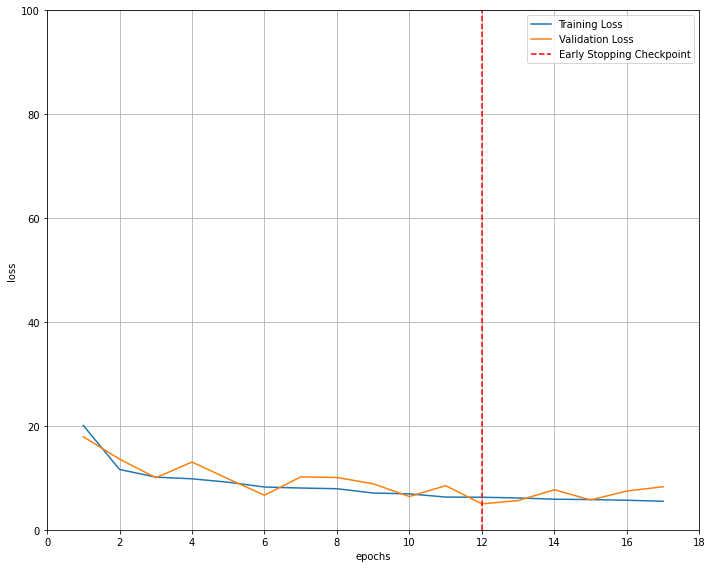

In [17]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 100) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [0]:
def test(net):
    predictions = []
    with torch.no_grad():
        for i, sample in enumerate(testloader):
            x ,y = sample
            x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
            
            x = x.to(device)
            y = y.to(device)
            
            predict = net(x)
            predict = predict.to("cpu")
            predict = np.array(predict)
            predictions.append(predict)
            

    print(predictions)
    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, 5)
    df = DataFrame(predictions)
    df.to_excel('predictions.xlsx', header=None)

In [19]:
trained_net = Net()
trained_net.load_state_dict(torch.load(LOAD_PRETRAINED_PATH))
trained_net.to(device)
trained_net.eval()
test(trained_net)

[array([[22.786236 , 13.978689 ,  8.056737 ,  6.261194 ,  3.1293979]],
      dtype=float32), array([[25.624529 , 13.505351 ,  6.4319315,  4.407345 ,  3.22703  ]],
      dtype=float32), array([[13.937472 , 23.777662 ,  4.134494 , 17.478527 ,  3.2353144]],
      dtype=float32), array([[22.12143  , 28.917122 , 11.653239 , 26.163946 ,  3.4147878]],
      dtype=float32), array([[16.427546 , 17.492668 ,  4.315385 , 14.429466 ,  3.2440171]],
      dtype=float32), array([[22.71421  , 27.894024 , 14.283344 , 26.570457 ,  3.3435001]],
      dtype=float32), array([[17.310137, 28.197037,  7.281182, 19.388931,  3.231713]],
      dtype=float32), array([[18.635242 , 28.74566  ,  3.2832608, 19.640955 ,  3.368268 ]],
      dtype=float32), array([[20.166893 , 10.426722 ,  7.0792785,  3.8742445,  3.018766 ]],
      dtype=float32), array([[17.895363 , 14.774372 ,  9.6956215, 10.317892 ,  3.053945 ]],
      dtype=float32), array([[19.249374 , 14.319135 ,  7.6420608, 11.215431 ,  3.1602128]],
      dtype=fl